# **Disaster Tweets Classification**

# **Introduction**

Social media platforms, especially Twitter, are often the first sources of real-time information during disasters. However, not all tweets related to disasters are actual reports—many are jokes, figurative speech, or unrelated content. The goal of this competition is to build a model that can distinguish between tweets that describe real disasters and those that do not.

## **Problem Statement**

Given a dataset of tweets, our objective is to develop a Natural Language Processing (NLP) model that predicts whether a tweet is about a real disaster (class 1) or not (class 0). This classification can help emergency responders and organizations filter critical information during crises.

## **Dataset Structure**

The dataset consists of two CSV files: `train.csv` and `test.csv`. Below is an overview of their size and structure.

### **Train Dataset (`train.csv`)**

- **Rows:** 8561
- **Columns:** 5
- **Columns Description:**
  - `id`: Unique identifier for the tweet
  - `text`: The actual tweet content
  - `keyword`: A keyword from the tweet (if available, can be missing)
  - `location`: User-provided location (contains missing values)
  - `target`: Binary label (1 = disaster-related, 0 = not disaster-related)

### **Test Dataset (`test.csv`)**

- **Rows:** 10,875
- **Columns:** 4 (same as `train.csv` but without the `target` column)


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Exploratory Data Analysis (EDA)

### **1. Target Variable Distribution**

The first visualization shows the distribution of the `target` variable, which indicates whether a tweet is about a real disaster (`1`) or not (`0`). The dataset is slightly imbalanced, with more non-disaster tweets than disaster-related tweets. This imbalance may affect model performance, requiring techniques such as resampling or class weighting.

### **2. Tweet Length Distribution**

The histogram of tweet lengths reveals that most tweets range between 80 and 140 characters, with a peak around 140 characters. This suggests that many tweets are near the Twitter character limit, which could influence how we preprocess the text (e.g., handling truncation, tokenization).

### **3. Missing Values**

The missing values heatmap shows that the `location` column has a significant amount of missing data, while `text` is fully populated likely because it is requried to tweet. The `location` column has the most missing values, which means it may not be a reliable feature unless handled properly. Possible approaches include filling missing values with placeholders, using it as an auxiliary feature, or dropping it if it adds little predictive value.

I also added a column called `text_length` as an additional feature since the length distribution could vaty between disaster and non-disaster tweets.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Summary Statistics:
                  id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN

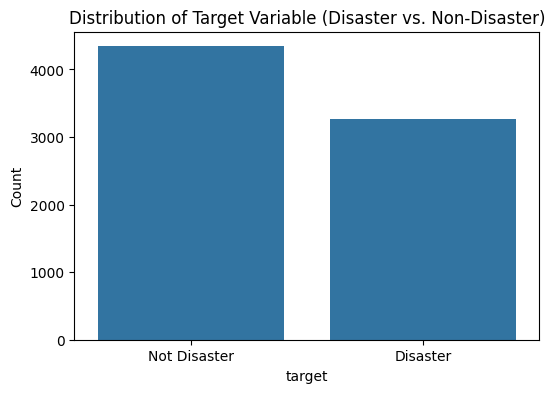

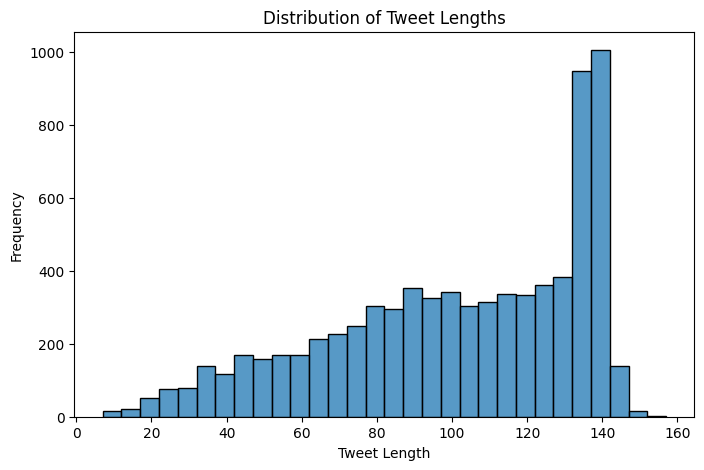

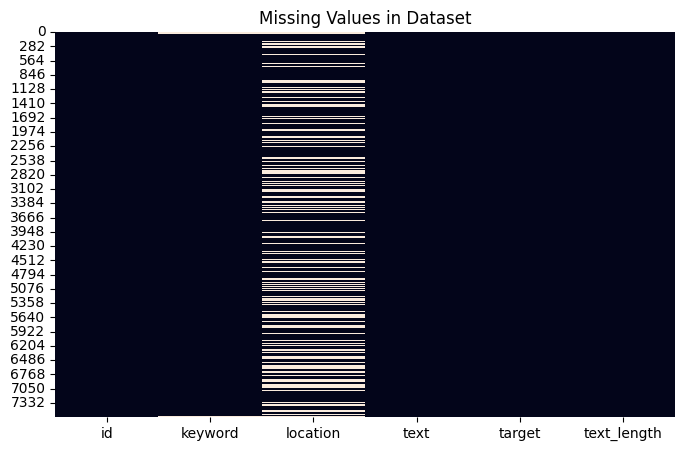

In [102]:
train_df = pd.read_csv("train.csv")

# Display basic info and summary statistics
print("Dataset Info:")
print(train_df.info())
print("\nSummary Statistics:")
print(train_df.describe(include="all"))

# Check for missing values
missing_values = train_df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Add a column for tweet length
train_df["text_length"] = train_df["text"].apply(len)

# Plot distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df["target"])
plt.title("Distribution of Target Variable (Disaster vs. Non-Disaster)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Not Disaster", "Disaster"])
plt.show()

# Plot histogram of tweet lengths
plt.figure(figsize=(8, 5))
sns.histplot(train_df["text_length"], bins=30)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

# Plot missing values as a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing Values in Dataset")
plt.show()

## Data Preprocessing

To prepare the dataset for modeling, we applied minimal yet effective preprocessing steps:

1. **Handling Missing Values**

   - The `location` column contained a significant number of missing values and was not crucial for classification, so I dropped it.
   - The `keyword` column also had missing values, which I filled with `unknown` to retain its presence as a feature.

2. **Text Cleaning**

   - I applied basic text preprocessing to the `text` column to improve consistency and reduce noise:
     - **Lowercased** all text to ensure uniformity.
     - **Removed URLs** to eliminate irrelevant information.
     - **Removed special characters and punctuation** to retain only alphanumeric text.
   - I created a **cleaned_text** column containing the processed version of the tweets.


In [103]:
# Drop the 'location' column
train_df.drop(columns=["location"])
train_df.drop(columns=["keyword"])


# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)  # Remove special characters and punctuation
    return text


# Apply text cleaning
train_df["cleaned_text"] = train_df["text"].apply(clean_text)

# Model Architecture

For this problem, I'm going to use a **Bidirectional Long Short-Term Memory (BiLSTM)** network .

### **Why BiLSTM?**

1. **Captures Context in Both Directions** – Unlike a standard LSTM, a BiLSTM processes the text both forward and backward, allowing it to understand dependencies better, which is crucial for tweets where context can appear anywhere in the sentence.
2. **Handles Sequential Data Well** – Since tweets are short texts with sequential patterns, LSTMs are great for capturing long-range dependencies compared to traditional feedforward networks.
3. **Performs Well on Text Classification** – LSTMs have been widely used in NLP tasks and can effectively capture the semantic meaning of tweets, making them ideal for this project and disaster classification.

### **Comparison against Simple RNN**

A basic alternative to BiLSTM is a Simple RNN, which processes text sequentially but lacks the memory capabilities of LSTMs. While BiLSTM captures context in both forward and backward directions, allowing for better understanding of dependencies, a Simple RNN struggles with long-range dependencies and often forgets earlier parts of the text.

In terms of computational cost, BiLSTM requires more resources but provides significantly better performance, whereas a Simple RNN is computationally cheaper but less effective for NLP tasks.

Overall, BiLSTM is a much better choice for this problem as it retains context and meaning more effectively, making it great for classifying tweets. Simple RNNs, on the other hand, tend to perform poorly in text classification due to their limited ability to handle long sequences.


## **Hyperparameter Optimization**

The hyperparameters I will be optimizing include the following and I will be using `KerasTuner` which is an automated TensorFlow tuning library.

1. **Vocabulary Size (`MAX_VOCAB_SIZE`)** – Controls how many unique words are kept in the tokenizer. A larger size captures more words but increases memory usage.
2. **Embedding Dimension (`EMBEDDING_DIM`)** – Determines the size of word vectors. Common values are 50, 100, or 300 when using pre-trained embeddings.
3. **LSTM Units (`LSTM_UNITS`)** – The number of hidden units in each LSTM layer. Higher values allow the model to learn more complex patterns but increase computation.


In [104]:
# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

# Tokenization and Padding
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["cleaned_text"])
sequences = tokenizer.texts_to_sequences(train_df["cleaned_text"])
padded_sequences = pad_sequences(
    sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)

# Prepare labels
labels = train_df["target"].values

In [105]:
# Define a function to build the model with only selected hyperparameters
def build_model(hp):
    model = Sequential(
        [
            Embedding(
                input_dim=hp.Choice("MAX_VOCAB_SIZE", [5000, 10000, 15000]),
                output_dim=hp.Choice("EMBEDDING_DIM", [50, 100, 150]),
            ),
            Bidirectional(
                LSTM(hp.Choice("LSTM_UNITS", [32, 64, 128]), return_sequences=True)
            ),
            Dropout(0.3),
            Bidirectional(LSTM(hp.Choice("LSTM_UNITS", [32, 64, 128]))),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-3),  # Fixed learning rate for faster tuning
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Initialize the tuner with fewer trials and faster pruning
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=5,  # Reduce max epochs for speed
    factor=4,  # Increase pruning speed
    directory="hyperparameter_tuning",
    project_name="disaster_tweets_optimized",
)

# Perform hyperparameter search
tuner.search(padded_sequences, labels, epochs=5, validation_split=0.2, batch_size=16)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f"Best Hyperparameters:")
print(f"MAX_VOCAB_SIZE: {best_hps.get('MAX_VOCAB_SIZE')}")
print(f"EMBEDDING_DIM: {best_hps.get('EMBEDDING_DIM')}")
print(f"LSTM_UNITS: {best_hps.get('LSTM_UNITS')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from hyperparameter_tuning\disaster_tweets_optimized\tuner0.json
Best Hyperparameters:
MAX_VOCAB_SIZE: 10000
EMBEDDING_DIM: 150
LSTM_UNITS: 64


# Results and Analysis

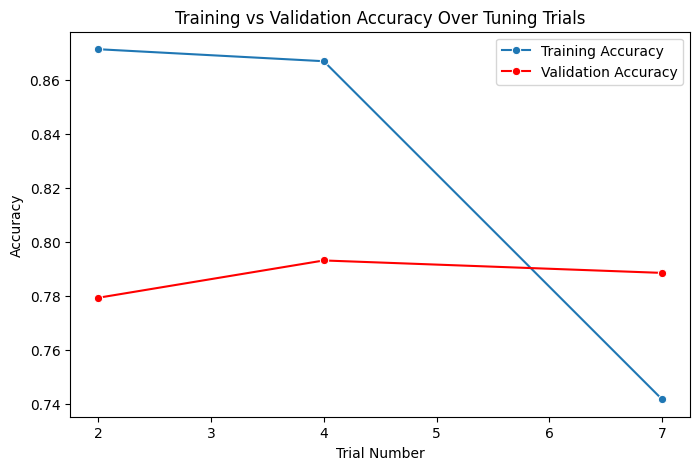

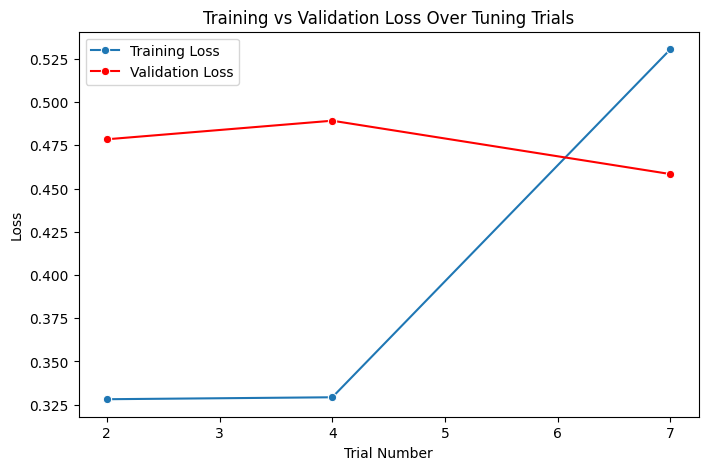

In [106]:
import os
import json

# List of trial directories trial_0001 to trial_000X
trial_dirs = [f"trial_{i:04d}" for i in range(1, 9)]

# List to store extracted data
trial_data = []

# Loop through each trial directory and extract metrics
for trial_dir in trial_dirs:
    trial_file = os.path.join(
        "hyperparameter_tuning", "disaster_tweets_optimized", trial_dir, "trial.json"
    )

    # Check if trial.json exists
    if os.path.exists(trial_file):
        with open(trial_file, "r") as file:
            trial_json = json.load(file)

        # Check if required metrics exist in JSON
        metrics = trial_json.get("metrics", {}).get("metrics", {})
        if all(
            key in metrics
            and "observations" in metrics[key]
            and metrics[key]["observations"]
            for key in ["accuracy", "loss", "val_accuracy", "val_loss"]
        ):
            # Extract relevant data
            trial_id = trial_json["trial_id"]
            accuracy = metrics["accuracy"]["observations"][0]["value"][0]
            loss = metrics["loss"]["observations"][0]["value"][0]
            val_accuracy = metrics["val_accuracy"]["observations"][0]["value"][0]
            val_loss = metrics["val_loss"]["observations"][0]["value"][0]

            trial_data.append(
                {
                    "Trial": int(trial_id),
                    "Accuracy": accuracy,
                    "Loss": loss,
                    "Validation Accuracy": val_accuracy,
                    "Validation Loss": val_loss,
                }
            )

# Convert to DataFrame for visualization
if trial_data:  # Ensure we have valid data before plotting
    df_trials = pd.DataFrame(trial_data).sort_values("Trial")

    # Plot accuracy over trials
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        x=df_trials["Trial"],
        y=df_trials["Accuracy"],
        marker="o",
        label="Training Accuracy",
    )
    sns.lineplot(
        x=df_trials["Trial"],
        y=df_trials["Validation Accuracy"],
        marker="o",
        label="Validation Accuracy",
        color="red",
    )
    plt.xlabel("Trial Number")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy Over Tuning Trials")
    plt.legend()
    plt.show()

    # Plot loss over trials
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        x=df_trials["Trial"], y=df_trials["Loss"], marker="o", label="Training Loss"
    )
    sns.lineplot(
        x=df_trials["Trial"],
        y=df_trials["Validation Loss"],
        marker="o",
        label="Validation Loss",
        color="red",
    )
    plt.xlabel("Trial Number")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss Over Tuning Trials")
    plt.legend()
    plt.show()
else:
    print("No valid trials with metrics found.")

In [107]:
# Load test dataset
test_df = pd.read_csv("test.csv")

# Preprocess test data (clean text, tokenize, pad)
test_df["cleaned_text"] = test_df["text"].apply(
    clean_text
)  # Apply same cleaning function
test_sequences = tokenizer.texts_to_sequences(test_df["cleaned_text"])
test_padded_sequences = pad_sequences(
    test_sequences, maxlen=MAX_SEQUENCE_LENGTH
)

# Get model predictions
predictions = best_model.predict(test_padded_sequences)
predicted_labels = (predictions > 0.5).astype(
    int
)  # Convert probabilities to binary labels

# Create a submission DataFrame with required format
submission_df = pd.DataFrame(
    {"id": test_df["id"], "target": predicted_labels.flatten()}
)

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully.")

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Submission file 'submission.csv' created successfully.


# **Conclusion**

Overall, my RNN model performed adequetly given the amount of time allocated for this project. To significantly improve the performance I would spend more time focusing on the data preprocessing as well as the hyperparameter tuning to achieve a better result.

### **Lessons Learned**

This project provided insights into classifying disaster-related tweets using a Recurrent Neural Network (RNN). Some of my key takeaways are:

- **Deep Learning Requires Careful Preprocessing:** Tokenization, padding sequences, and handling imbalanced data played a crucial role in model performance.
- **Hyperparameter Tuning is Essential:** Adjusting parameters like the number of LSTM units, dropout rate, and learning rate significantly impacted results.

### **What Worked Well**

- Using an **LSTM-based model** with bidirectional layers helped capture context in tweet sequences compared to other simplier RNN models.
- Applying **embedding layers** improved feature representation and boosted model performance.

### **What Didn’t Work**

- **Overfitting:** The model performed well on training data but struggled with validation data at times and resulted it a relatively mediocre score.
- **Handling Noisy Data:** The variation in tweet content requires complex data preprocessing to properly normalize and clean the data for training.
- **Longer Training Times:** Training and hyperparameter tuning the models took significantly longer than traditional machine learning approaches.

### **Improvements & Future Work**

- **Experimenting with Pre-Trained Embeddings:** Using word embeddings like GloVe or FastText could improve contextual understanding.
- **Regularization Techniques:** Implementing dropout and batch normalization could further reduce overfitting. Additionally, if given more time, I would run the hyperparameter tuning with significantly more variables.
- **Exploring Transformer-Based Models:** BERT or GPT-based approaches might outperform RNNs on short-text classification tasks.
